# LSTM PREDICTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.callbacks import TensorBoard

2021-12-08 12:24:18.265765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 12:24:18.265785: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',', parse_dates=["DateTime"])

In [3]:
df_lstm = df.set_index('DateTime')
df_lstm = df_lstm.resample('h').mean()
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
df_lstm = df_lstm.join(temperatures, how="left", on='Date')
df_lstm = df_lstm.drop(columns=['Date','max_t','min_t'])
#df_lstm["Day"] = df_lstm.index.dayofweek+1
#y = pd.get_dummies(df_lstm.Day, prefix='Day')
#df_lstm = df_lstm.join(y, how="left")
#df_lstm = df_lstm.drop(columns=["Day"])
df_lstm = df_lstm.drop(columns=["Global_reactive_power"])
df_lstm.head()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
DateTime,,,,,,,
2006-12-16 17:00:00,4.222889,234.643889,18.100000,0.0,0.527778,16.861111,4.6
2006-12-16 18:00:00,3.632200,234.580167,15.600000,0.0,6.716667,16.866667,4.6
2006-12-16 19:00:00,3.400233,233.232500,14.503333,0.0,1.433333,16.683333,4.6
2006-12-16 20:00:00,3.268567,234.071500,13.916667,0.0,0.000000,16.783333,4.6
2006-12-16 21:00:00,3.056467,237.158667,13.046667,0.0,0.416667,17.216667,4.6


In [4]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_lstm[df_lstm.columns] = scaler.fit_transform(df_lstm[df_lstm.columns])
df_lstm.describe()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,-0.699358,0.151240,-0.704151,-0.953628,-0.944072,-0.400498,-0.206999
std,0.277552,0.229066,0.268258,0.145439,0.179507,0.678826,0.389977
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.931744,0.025555,-0.927068,-1.000000,-1.000000,-0.939675,-0.502959
50%,-0.786666,0.161817,-0.788140,-1.000000,-0.985642,-0.845321,-0.242604
75%,-0.549333,0.292478,-0.564084,-1.000000,-0.971285,0.296210,0.076923
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_lstm.head(3)

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
DateTime,,,,,,,
2006-12-16 17:00:00,0.273632,-0.324109,0.262315,-1.0,-0.977267,0.564836,0.029586
2006-12-16 18:00:00,0.090090,-0.328998,0.082975,-1.0,-0.710696,0.565352,0.029586
2006-12-16 19:00:00,0.018012,-0.432397,0.004304,-1.0,-0.938263,0.548337,0.029586


In [6]:
# def data_to_supervised(df, steps_ahead = 1, col_to_predict="Global_active_power"):
#     data = pd.DataFrame(df)
#     n_vars = data.shape[1]
#     columns = []
#     columns.append(data.shift(0))
#     # temp = data.shift(0)
#     columns.append(data.shift(-steps_ahead)[col_to_predict])
#     df_labeled = pd.concat(columns, axis=1)
#     names = [col + "(t-1)" for col in df.columns]
#     names.append(f"{col_to_predict}(t)")
#     print(names)
#     df_labeled.columns = names
#     df_labeled.dropna(inplace=True)
    
#     return df_labeled

def data_to_supervised(df, col_to_predict="Global_active_power"):
    data = pd.DataFrame(df)
    n_vars = data.shape[1]
    columns = []
    columns.append(data.shift(1))
    # temp = data.shift(0)
    columns.append(data.shift(0)[col_to_predict])
    df_labeled = pd.concat(columns, axis=1)
    names = [col + "(t-1)" for col in df.columns]
    names.append(f"{col_to_predict}(t)")
    print(names)
    df_labeled.columns = names
    df_labeled.dropna(inplace=True)
    
    return df_labeled

In [7]:
df_lstm = data_to_supervised(df_lstm)
df_lstm.head(5)

['Global_active_power(t-1)', 'Voltage(t-1)', 'Global_intensity(t-1)', 'Sub_metering_1(t-1)', 'Sub_metering_2(t-1)', 'Sub_metering_3(t-1)', 'avg_t(t-1)', 'Global_active_power(t)']


,Global_active_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),avg_t(t-1),Global_active_power(t)
DateTime,,,,,,,,
2006-12-16 18:00:00,0.273632,-0.324109,0.262315,-1.0,-0.977267,0.564836,0.029586,0.090090
2006-12-16 19:00:00,0.090090,-0.328998,0.082975,-1.0,-0.710696,0.565352,0.029586,0.018012
2006-12-16 20:00:00,0.018012,-0.432397,0.004304,-1.0,-0.938263,0.548337,0.029586,-0.022901
2006-12-16 21:00:00,-0.022901,-0.368025,-0.037781,-1.0,-1.000000,0.557618,0.029586,-0.088806
2006-12-16 22:00:00,-0.088806,-0.131166,-0.100191,-1.0,-0.982053,0.597834,0.029586,-0.354891


In [8]:
values = df_lstm.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 27670
(27670, 1, 7) (27670,) (6918, 1, 7) (6918,)


In [9]:
model = Sequential()
#recurrent_activation ='selu' # 1er place
#recurrent_activation ='softsign' # 2e place

model.add(LSTM(125, input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_activation ='sigmoid',activation='tanh',return_sequences=False))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh',return_sequences=True))
#model.add(LSTM(2*24,recurrent_activation ='sigmoid',activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_absolute_error', optimizer='adam')
#model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.001),
             # loss=tensorflow.keras.losses.MeanSquaredError(),
             # metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               66500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 66,626
Trainable params: 66,626
Non-trainable params: 0
_________________________________________________________________


2021-12-08 12:24:29.375918: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-08 12:24:29.375951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2021-12-08 12:24:29.376216: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# fit network
history = model.fit(train_X, train_y, epochs=75, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/75
396/396 - 2s - loss: 0.1554 - val_loss: 0.1216 - 2s/epoch - 6ms/step
Epoch 2/75
396/396 - 1s - loss: 0.1362 - val_loss: 0.1197 - 839ms/epoch - 2ms/step
Epoch 3/75
396/396 - 1s - loss: 0.1326 - val_loss: 0.1207 - 848ms/epoch - 2ms/step
Epoch 4/75
396/396 - 1s - loss: 0.1314 - val_loss: 0.1202 - 847ms/epoch - 2ms/step
Epoch 5/75
396/396 - 1s - loss: 0.1304 - val_loss: 0.1191 - 849ms/epoch - 2ms/step
Epoch 6/75
396/396 - 1s - loss: 0.1300 - val_loss: 0.1172 - 842ms/epoch - 2ms/step
Epoch 7/75
396/396 - 1s - loss: 0.1292 - val_loss: 0.1186 - 838ms/epoch - 2ms/step
Epoch 8/75
396/396 - 1s - loss: 0.1292 - val_loss: 0.1169 - 843ms/epoch - 2ms/step
Epoch 9/75
396/396 - 1s - loss: 0.1289 - val_loss: 0.1155 - 849ms/epoch - 2ms/step
Epoch 10/75
396/396 - 1s - loss: 0.1288 - val_loss: 0.1151 - 856ms/epoch - 2ms/step
Epoch 11/75
396/396 - 1s - loss: 0.1289 - val_loss: 0.1146 - 837ms/epoch - 2ms/step
Epoch 12/75
396/396 - 1s - loss: 0.1286 - val_loss: 0.1148 - 846ms/epoch - 2ms/step
Epoc

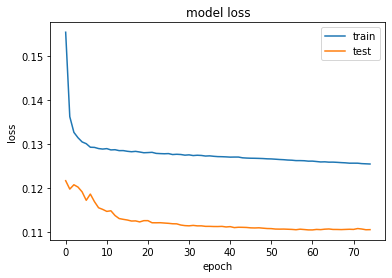

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
size = df_lstm.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

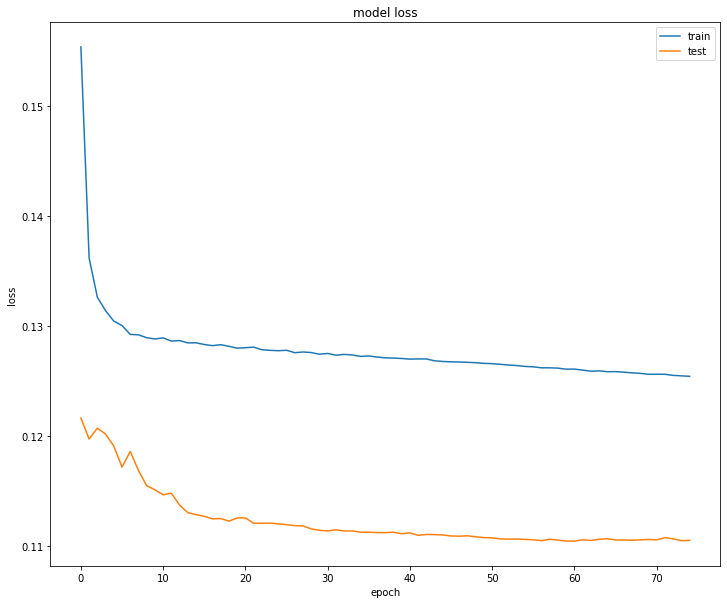

In [13]:
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.537


In [15]:
# print("test")

In [16]:
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

0.45482032534076233
0.45426804491780803


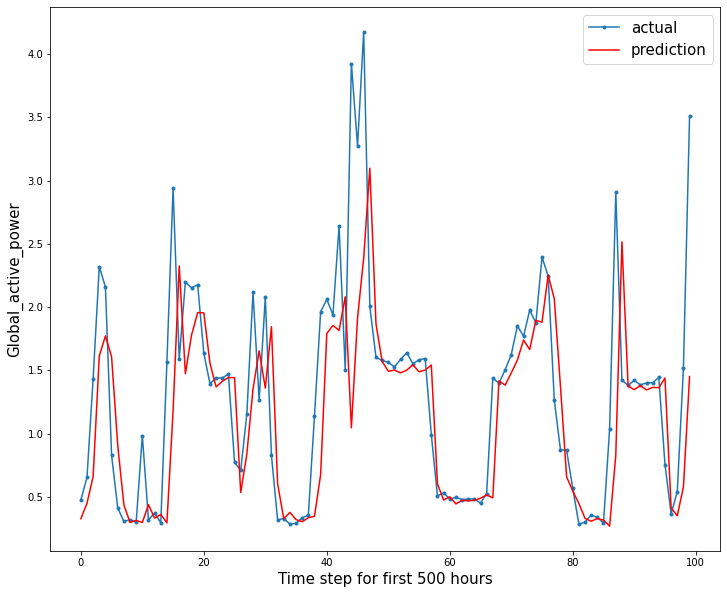

In [18]:
aa=[x for x in range(100)]
plt.figure(figsize=(12,10))
plt.plot(aa, inv_y[:100], marker='.', label="actual")
plt.plot(aa, inv_yhat[:100], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

# LSTM by Day

In [37]:
df_lstm = df.set_index('DateTime')
df_lstm = df_lstm.resample('h').mean()
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
df_lstm = df_lstm.join(temperatures, how="left", on='Date')
df_lstm = df_lstm.drop(columns=['Date','max_t','min_t'])
#df_lstm["Day"] = df_lstm.index.dayofweek+1
#y = pd.get_dummies(df_lstm.Day, prefix='Day')
#df_lstm = df_lstm.join(y, how="left")
#df_lstm = df_lstm.drop(columns=["Day"])
df_lstm = df_lstm.drop(columns=["Global_reactive_power"])
df_lstm2 = df_lstm.resample('d').mean()
df_lstm2.head(5)

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
DateTime,,,,,,,
2006-12-16,3.120298,236.152341,13.369524,0.000000,1.330159,12.692063,4.60
2006-12-17,2.354486,240.087028,9.999028,1.411806,2.907639,9.264583,2.40
2006-12-18,1.530435,241.231694,6.421667,0.738194,1.820139,9.734722,3.40
2006-12-19,1.157079,241.999313,4.926389,0.582639,5.279167,4.303472,1.25
2006-12-20,1.545658,242.308063,6.467361,0.000000,1.838889,9.765972,2.35


In [38]:
scaler2 = MinMaxScaler(feature_range=(-1,1))
df_lstm2[df_lstm2.columns] = scaler2.fit_transform(df_lstm2[df_lstm2.columns])
df_lstm2.describe()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,-0.415015,0.192762,-0.421554,-0.711249,-0.691183,-0.285828,-0.206912
std,0.265468,0.247181,0.261270,0.282645,0.343899,0.326069,0.390053
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.583958,0.103188,-0.589880,-0.873830,-0.928566,-0.513293,-0.502959
50%,-0.419776,0.207080,-0.429419,-0.799094,-0.881989,-0.286225,-0.242604
75%,-0.273436,0.317815,-0.285779,-0.605388,-0.551395,-0.071254,0.076923
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
df_lstm2 = data_to_supervised(df_lstm2)
df_lstm2.head(3)

['Global_active_power(t-1)', 'Voltage(t-1)', 'Global_intensity(t-1)', 'Sub_metering_1(t-1)', 'Sub_metering_2(t-1)', 'Sub_metering_3(t-1)', 'avg_t(t-1)', 'Global_active_power(t)']


,Global_active_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),avg_t(t-1),Global_active_power(t)
DateTime,,,,,,,,
2006-12-17,0.876122,-0.380415,0.900371,-1.000000,-0.683636,0.513121,0.029586,0.388504
2006-12-18,0.388504,0.100987,0.390452,-0.636293,-0.308448,0.073525,-0.491124,-0.136197
2006-12-19,-0.136197,0.241035,-0.150764,-0.809828,-0.567099,0.133823,-0.254438,-0.373925


In [40]:
values = df_lstm2.values

trainsize = 0.8
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 1153
(1153, 1, 7) (1153,) (288, 1, 7) (288,)


In [41]:
model = Sequential()
model.add(LSTM(7, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7)                 420       
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 428
Trainable params: 428
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(train_X, train_y, epochs=75, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/75
1153/1153 - 3s - loss: 0.0519 - val_loss: 0.0395 - 3s/epoch - 2ms/step
Epoch 2/75
1153/1153 - 1s - loss: 0.0437 - val_loss: 0.0382 - 1s/epoch - 1ms/step
Epoch 3/75
1153/1153 - 1s - loss: 0.0429 - val_loss: 0.0382 - 1s/epoch - 1ms/step
Epoch 4/75
1153/1153 - 1s - loss: 0.0423 - val_loss: 0.0381 - 1s/epoch - 1ms/step
Epoch 5/75
1153/1153 - 1s - loss: 0.0419 - val_loss: 0.0379 - 1s/epoch - 1ms/step
Epoch 6/75
1153/1153 - 1s - loss: 0.0416 - val_loss: 0.0377 - 1s/epoch - 1ms/step
Epoch 7/75
1153/1153 - 1s - loss: 0.0413 - val_loss: 0.0374 - 1s/epoch - 1ms/step
Epoch 8/75
1153/1153 - 1s - loss: 0.0411 - val_loss: 0.0371 - 1s/epoch - 1ms/step
Epoch 9/75
1153/1153 - 1s - loss: 0.0409 - val_loss: 0.0368 - 1s/epoch - 1ms/step
Epoch 10/75
1153/1153 - 1s - loss: 0.0408 - val_loss: 0.0365 - 1s/epoch - 1ms/step
Epoch 11/75
1153/1153 - 1s - loss: 0.0407 - val_loss: 0.0361 - 1s/epoch - 1ms/step
Epoch 12/75
1153/1153 - 1s - loss: 0.0405 - val_loss: 0.0358 - 1s/epoch - 1ms/step
Epoch 13/75
1

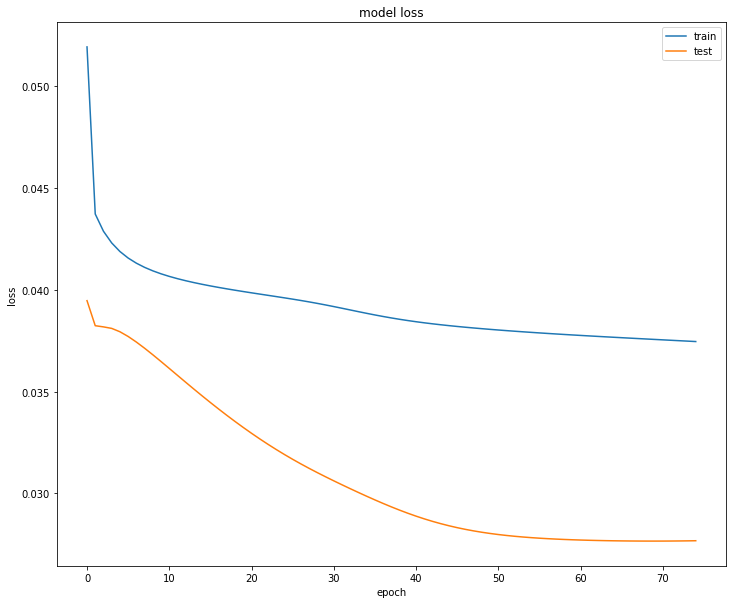

In [43]:
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
size = df_lstm2.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler2.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler2.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [44]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.953


In [45]:
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

-9.073095593123314
-9.324922982951398


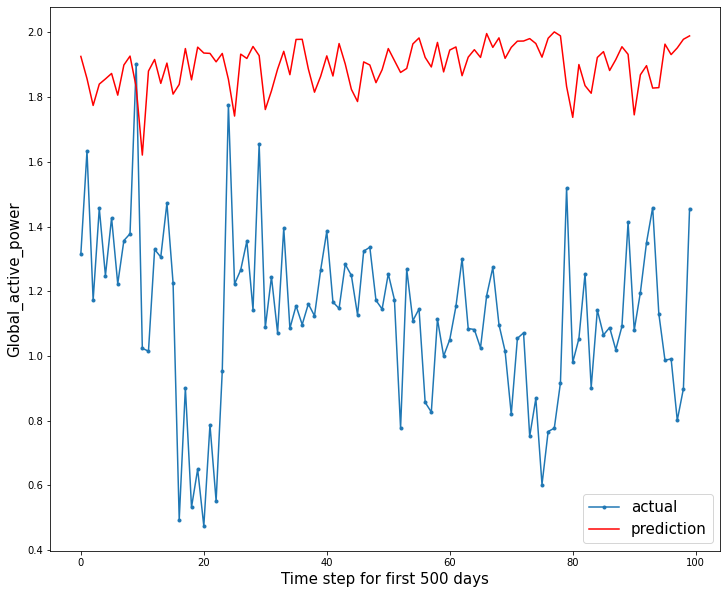

In [46]:
aa=[x for x in range(100)]
plt.figure(figsize=(12,10))
plt.plot(aa, inv_y[:100], marker='.', label="actual")
plt.plot(aa, inv_yhat[:100], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel('Time step for first 500 days', size=15)
plt.legend(fontsize=15)
plt.show()

# LSTM by minute

In [47]:
df_lstm = df.set_index('DateTime')
# df_lstm = df_lstm.resample('h').mean()
df_lstm['Date'] = pd.to_datetime(df_lstm.index.date)
temperatures = pd.read_csv("pre_processing/temperatures.csv", parse_dates=['Date'], index_col='Date')
temperatures['avg_t'] = (temperatures['max_t'] - temperatures['min_t'])/2
df_lstm = df_lstm.join(temperatures, how="left", on='Date')
df_lstm = df_lstm.drop(columns=['Date','max_t','min_t'])
#df_lstm["Day"] = df_lstm.index.dayofweek+1
#y = pd.get_dummies(df_lstm.Day, prefix='Day')
#df_lstm = df_lstm.join(y, how="left")
#df_lstm = df_lstm.drop(columns=["Day"])
df_lstm = df_lstm.drop(columns=["Global_reactive_power"])
# df_lstm2 = df_lstm.resample('d').mean()
# df_lstm2.head(5)

In [48]:
scaler = MinMaxScaler(feature_range=(-1,1))
df_lstm[df_lstm.columns] = scaler.fit_transform(df_lstm[df_lstm.columns])
df_lstm.describe()

,Global_active_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,avg_t
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,-8.161299e-01,1.398757e-01,-8.162930e-01,-9.745122e-01,-9.675372e-01,-5.832460e-01,-2.069884e-01
std,1.904368e-01,2.082981e-01,1.834536e-01,1.389810e-01,1.446527e-01,5.415017e-01,3.899690e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-9.576317e-01,2.164782e-02,-9.502075e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-5.029586e-01
50%,-9.022271e-01,1.502423e-01,-8.921162e-01,-1.000000e+00,-1.000000e+00,-9.354839e-01,-2.426036e-01
75%,-7.374615e-01,2.704362e-01,-7.427386e-01,-1.000000e+00,-9.750000e-01,9.677419e-02,7.692308e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [49]:
df_lstm = data_to_supervised(df_lstm)
df_lstm.head(3)

['Global_active_power(t-1)', 'Voltage(t-1)', 'Global_intensity(t-1)', 'Sub_metering_1(t-1)', 'Sub_metering_2(t-1)', 'Sub_metering_3(t-1)', 'avg_t(t-1)', 'Global_active_power(t)']


,Global_active_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),avg_t(t-1),Global_active_power(t)
DateTime,,,,,,,,
2006-12-16 17:25:00,-0.250407,-0.247819,-0.244813,-1.0,-0.975,0.096774,0.029586,-0.043274
2006-12-16 17:26:00,-0.043274,-0.326010,-0.053942,-1.0,-0.975,0.032258,0.029586,-0.040739
2006-12-16 17:27:00,-0.040739,-0.347981,-0.053942,-1.0,-0.950,0.096774,0.029586,-0.038204


In [50]:
values = df_lstm.values

trainsize = 0.80
n_rows = round(len(values)*trainsize)
print(f"Taille du trainset : {n_rows}")

train = values[:n_rows, :]
test = values[n_rows:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D format as expected by LSTMs [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Taille du trainset : 1660206
(1660206, 1, 7) (1660206,) (415052, 1, 7) (415052,)


In [51]:
model = Sequential()
model.add(LSTM(3*60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 180)               135360    
                                                                 
 dense_4 (Dense)             (None, 1)                 181       
                                                                 
Total params: 135,541
Trainable params: 135,541
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(train_X, train_y, epochs=5, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/5
16603/16603 - 50s - loss: 0.0031 - val_loss: 0.0022 - 50s/epoch - 3ms/step
Epoch 2/5
16603/16603 - 48s - loss: 0.0027 - val_loss: 0.0016 - 48s/epoch - 3ms/step
Epoch 3/5
16603/16603 - 48s - loss: 0.0025 - val_loss: 0.0016 - 48s/epoch - 3ms/step
Epoch 4/5
16603/16603 - 48s - loss: 0.0025 - val_loss: 0.0015 - 48s/epoch - 3ms/step
Epoch 5/5
16603/16603 - 48s - loss: 0.0025 - val_loss: 0.0015 - 48s/epoch - 3ms/step


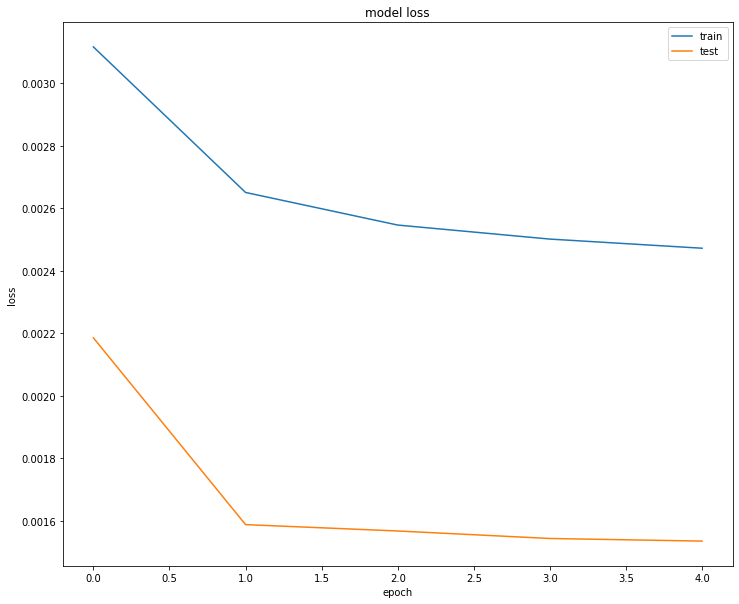

In [53]:
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [54]:
size = df_lstm.shape[1]-1
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], size))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [55]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.216


In [56]:
import sklearn
r2 = sklearn.metrics.r2_score(inv_y, inv_yhat)
print(r2)
r_adjusted = 1 - ( 1-r2 ) * ( len(test_y) - 1 ) / ( len(test_y) - test_X.shape[1] - 1 )
print(r_adjusted)

0.9390695180301031
0.9390684903959877


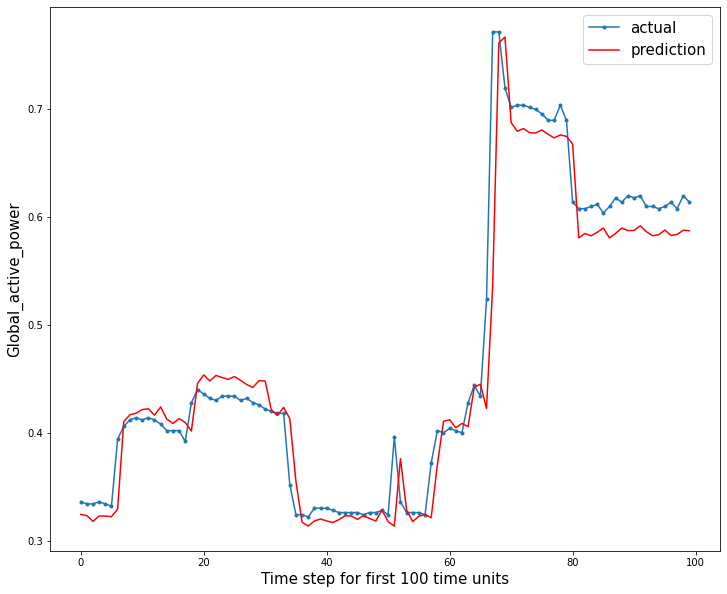

In [57]:
nbr_step = 100
aa=[x for x in range(nbr_step)]
plt.figure(figsize=(12,10))
plt.plot(aa, inv_y[:nbr_step], marker='.', label="actual")
plt.plot(aa, inv_yhat[:nbr_step], 'r', label="prediction")
plt.ylabel(df.columns[1], size=15)
plt.xlabel(f'Time step for first {nbr_step} time units', size=15)
plt.legend(fontsize=15)
plt.show()